In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [103]:
transform = transforms.Compose([transforms.ToTensor(),
                                # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                transforms.Resize(750), 
                                transforms.CenterCrop(750),
                                transforms.Grayscale()])

In [104]:
dataset = datasets.ImageFolder("Dataset", transform=transform)
class_name = dataset.classes

In [198]:
train_size = int(0.75*(len(dataset))+1)
test_size = int(0.25*(len(dataset)))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [234]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=40)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_size)

Label: [0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0
 1 1 0]
Class: normal normal potholes normal normal potholes potholes potholes potholes normal normal potholes normal normal potholes potholes normal normal potholes normal normal potholes normal normal normal potholes normal normal potholes normal normal normal potholes normal normal normal normal potholes potholes normal


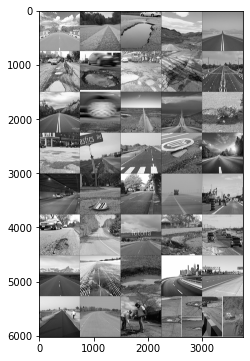

In [200]:
for image, label in train_loader:
    break

print('Label:', label.numpy())
print('Class:', *np.array([class_name[i] for i in label]))

# the default nrow is 8
im = make_grid(image, nrow=5)  

# Print the images
plt.figure(figsize=(14,6))
plt.imshow(np.transpose(im, (1, 2, 0)))

In [261]:
conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=2)
conv2 = nn.Conv2d(6, 10, kernel_size=5, stride=2)
# conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=3)
# dropout = nn.Dropout(0.5)
fc1 = nn.Linear(7*7*64, 120)
fc2 = nn.Linear(120, 2)

In [262]:
for i , (X_train,Y_train) in enumerate(train_loader):
    break
X_train.shape

torch.Size([40, 1, 750, 750])

In [263]:
X = F.relu(conv1(X_train))
# X = dropout(X)
X = F.max_pool2d(X, 2, 2)
X = F.relu(conv2(X))
# X = dropout(X)
X = F.max_pool2d(X, 2, 2)
# X = F.relu(conv3(X))
# X = F.max_pool2d(X, 3, 3)
# X = dropout(X)
# X = F.max_pool2d(X, 2, 2)
# X = F.relu(conv4(X))
# X = dropout(X)
# X = F.max_pool2d(X, 2, 2)

In [264]:
X.shape

torch.Size([40, 10, 45, 45])

In [293]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=5, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(10)
        # self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=3)
        # self.batchnorm1 = nn.BatchNorm2d(32)
        # self.fc1 = nn.Linear(16*46*46, 128)
        self.fc1 = nn.Linear(10*45*45, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        # X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        X = self.batchnorm1(X)
        X = F.relu(self.conv2(X))
        # X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        X = self.batchnorm2(X)
        # X = F.relu(self.conv3(X))
        # X = F.max_pool2d(X, 3, 3)
        # X = F.relu(self.conv4(X))
        # X = self.dropout(X)
        # X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 10*45*45)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        
        return F.log_softmax(X, dim=1)

In [294]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.00001)

In [295]:
epoch = 7
losses = []
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epoch):
    trn_corr = 0
    tst_corr = 0

    for b,(x_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(x_train)
        loss = criterion(y_pred,y_train)
     
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        # print('yes')
        if b%4 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{40*b:6}/545]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(40*b):7.3f}%')
        elif b == 13:
            print(f'epoch: {i:2}  batch: {b:4} [{40*b:6}/545]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(40*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
    
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

epoch:  0  batch:    4 [   160/545]  loss: 0.54260719 accuracy:  62.500%
epoch:  0  batch:    8 [   320/545]  loss: 0.70849079 accuracy:  68.125%
epoch:  0  batch:   12 [   480/545]  loss: 0.53815001 accuracy:  68.958%
epoch:  0  batch:   13 [   520/545]  loss: 0.52073902 accuracy:  68.077%
epoch:  1  batch:    4 [   160/545]  loss: 0.21561106 accuracy:  92.500%
epoch:  1  batch:    8 [   320/545]  loss: 0.22700152 accuracy:  92.500%
epoch:  1  batch:   12 [   480/545]  loss: 0.28491691 accuracy:  91.667%
epoch:  1  batch:   13 [   520/545]  loss: 0.22044808 accuracy:  90.000%
epoch:  2  batch:    4 [   160/545]  loss: 0.17873922 accuracy:  92.500%
epoch:  2  batch:    8 [   320/545]  loss: 0.19928867 accuracy:  94.688%
epoch:  2  batch:   12 [   480/545]  loss: 0.24561357 accuracy:  95.000%
epoch:  2  batch:   13 [   520/545]  loss: 0.09341233 accuracy:  93.654%
epoch:  3  batch:    4 [   160/545]  loss: 0.15228231 accuracy:  98.750%
epoch:  3  batch:    8 [   320/545]  loss: 0.066268

In [296]:
# for i in range(len(test_correct)):
    # print(test_correct[i].item(),i,(test_correct[i].item()*100/(len(test_loader)*10)))
print(f'Test accuracy: {test_correct[-1].item()*100/(test_size):.3f}%')

Test accuracy: 72.353%


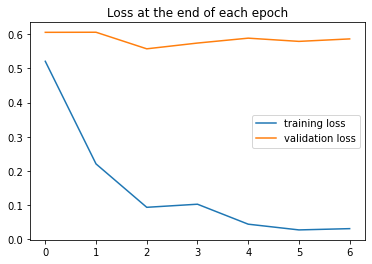

In [297]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

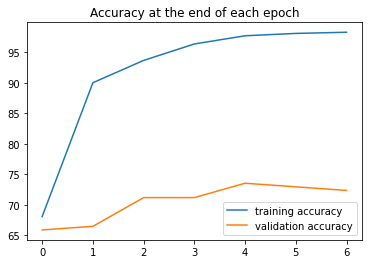

In [298]:
plt.plot([t*100/(len(train_loader)*40) for t in train_correct], label='training accuracy')
plt.plot([t*100/(test_size) for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()